In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

#import stheno.torch as s"theno

#import convcnp.data
from convcnp.experiment import report_loss, RunningAverage
from convcnp.utils import gaussian_logpdf, init_sequential_weights, to_multiple
#from convcnp.architectures import SimpleConv, UNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [2]:
#import mogptk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [3]:

import time 
import random
random_seed = 1111
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [4]:
def to_numpy(x):
    """Convert a PyTorch tensor to NumPy."""
    return x.squeeze().detach().cpu().numpy()

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
figsiz_=(11,2.5*2)
fontsiz = 18


plt.rc('figure', figsize=figsiz_,dpi=100)
plt.rcParams['figure.figsize'] = figsiz_
plt.rc('font', family='serif', size=fontsiz)

sotonmet['Date']## preparation dataset: bramblemet
### checked working but exploration quite not fitted well

In [6]:
from collections import OrderedDict

# start_date = '2020-06-02'
# end_date = '2020-06-07' #work doen checked

cols = ['bramblemet','cambermet','chimet','sotonmet']
start_date = '2020-05-01'
starts =  pd.to_datetime('01/05/2020 00:00', format='%d/%m/%Y %H:%M')

end_date = '2020-07-01'
#end_date_ = '2020-06-30'
#totaldays=22+30


#totalnumobs = totaldays*24*12
print('Loading Bramble')
bramblemet = pd.read_csv('data/bramblemet/bramblemet.csv.gz', compression='gzip', low_memory=False)
bramblemet['Date'] = pd.to_datetime(bramblemet['Date'] + ' ' + bramblemet['Time'], format='%d/%m/%Y %H:%M')
bramblemet = bramblemet.drop(columns=['Time'])
bramblemet = bramblemet.loc[(bramblemet['Date'] >= start_date) & (bramblemet['Date'] < end_date)]

print('Loading Camber')
cambermet = pd.read_csv('data/bramblemet/cambermet.csv.gz', compression='gzip', low_memory=False)
cambermet['Date'] = pd.to_datetime(cambermet['Date'] + ' ' + cambermet['Time'], format='%d/%m/%Y %H:%M')
cambermet = cambermet.drop(columns=['Time'])
cambermet = cambermet.loc[(cambermet['Date'] >= start_date) & (cambermet['Date'] < end_date)]

print('Loading Chi')
chimet = pd.read_csv('data/bramblemet/chimet.csv.gz', compression='gzip', low_memory=False)
chimet['Date'] = pd.to_datetime(chimet['Date'] + ' ' + chimet['Time'], format='%d/%m/%Y %H:%M')
chimet = chimet.drop(columns=['Time'])
chimet = chimet.loc[(chimet['Date'] >= start_date) & (chimet['Date'] < end_date)]

print('Loading Soton')
sotonmet = pd.read_csv('data/bramblemet/sotonmet.csv.gz', compression='gzip', low_memory=False)
sotonmet['Date'] = pd.to_datetime(sotonmet['Date'] + ' ' + sotonmet['Time'], format='%d/%m/%Y %H:%M')
sotonmet = sotonmet.drop(columns=['Time'])
sotonmet = sotonmet.loc[(sotonmet['Date'] >= start_date) & (sotonmet['Date'] < end_date)]


# startfloat = sotonmet['Date'][sotonmet['Date'] == '2020-06-01 00:00:00'].to_numpy().astype('float32') 
# endfloat = sotonmet['Date'][sotonmet['Date'] == '2020-06-30 23:55:00'].to_numpy().astype('float32')

# startfloat = chimet['Date'][chimet['Date'] == start_date + ' 00:00:00'].to_numpy().astype('float32') 
# endfloat = sotonmet['Date'][sotonmet['Date'] == end_date_ + ' 23:55:00'].to_numpy().astype('float32')


normalize=True
dataset_dict = OrderedDict()
dataset_dict[0] = bramblemet
dataset_dict[1] = cambermet
dataset_dict[2] = chimet
dataset_dict[3] = sotonmet


Loading Bramble
Loading Camber
Loading Chi
Loading Soton


In [7]:
dataset_dict['total_day'] = 61
dataset_dict['split_day'] = 31
dataset_dict['duration'] = 4
#dataset_dict['duration'] = 1.5

dataset_dict['unit'] = 24
dataset_dict['unit2'] = 1

In [8]:


num_channels = 4
#default_round = 100000000000
default_round = 10**11




#for ith_dict in dataset_dict:
for ith_dict in range(num_channels):    
    #x = dataset_dict[ith_dict]['Date'].to_numpy().astype('int')/default_round
    #x = dataset_dict[ith_dict]['Date'].to_numpy(dtype=np.float32)     
    #x = ((dataset_dict[ith_dict]['Date']  -starts)  / (pd.Timedelta('1s')*60*60)).to_numpy(dtype=np.float32)           
    #x = ((dataset_dict[ith_dict]['Date']  -starts)  / (24*(pd.Timedelta('1h'))) ).to_numpy(dtype=np.float32)           
    x = ((dataset_dict[ith_dict]['Date']  -starts)  / (1*(pd.Timedelta('1h'))) ).to_numpy(dtype=np.float32)           
    
    y = dataset_dict[ith_dict]['DEPTH'].to_numpy(dtype=np.float32)    
    #dataset_dict[ith_dict] = 
    #x,y = np.asarray(x,dtype=np.float32),np.asarray(y,dtype=np.float32)
    
    dataset_dict[ith_dict] = {}
    dataset_dict[ith_dict]['x'] = x
    dataset_dict[ith_dict]['y'] = y
    
    
    x0 = dataset_dict[ith_dict]['x'][0]
    if normalize == True:
        #dataset_dict[ith_dict]['x'] -= x0 
        #dataset_dict[ith_dict]['x'] /= time_scale        
        dataset_dict[ith_dict]['ymean'] = dataset_dict[ith_dict]['y'].mean()
        dataset_dict[ith_dict]['ystd'] = dataset_dict[ith_dict]['y'].std() 
        dataset_dict[ith_dict]['y'] = (dataset_dict[ith_dict]['y'] - dataset_dict[ith_dict]['ymean'])/dataset_dict[ith_dict]['ystd']

    idx = np.argsort(dataset_dict[ith_dict]['x'])
    dataset_dict[ith_dict]['x'] = dataset_dict[ith_dict]['x'][idx]/dataset_dict['unit']
    dataset_dict[ith_dict]['y'] = dataset_dict[ith_dict]['y'][idx]        

    #rescale_x
    dataset_dict[ith_dict]['x'] = dataset_dict[ith_dict]['x'][::12]
    dataset_dict[ith_dict]['y'] = dataset_dict[ith_dict]['y'][::12]
    
    
# startfloat -=x0 
# endfloat -=x0
    
    
    


In [9]:
len(dataset_dict[0]['x'])

1110

In [10]:
dataset_dict[0]

{'x': array([0.0000000e+00, 5.9027776e-02, 1.0763889e-01, ..., 6.0895832e+01,
        6.0944443e+01, 6.0993057e+01], dtype=float32),
 'y': array([-0.45959923, -0.41981125, -0.05177235, ...,  1.420384  ,
         0.90313977, -0.29050037], dtype=float32),
 'ymean': 2.912048,
 'ystd': 1.0053282}

In [11]:
# chosen_day = np.random.randint(dataset_dict['duration'],dataset_dict['split_day']-dataset_dict['duration'])
# chosen_day = np.random.randint(dataset_dict['split_day']+dataset_dict['duration'],dataset_dict['total_day']-dataset_dict['duration'])

In [12]:

def nparray2tensor(context_x,context_y,target_x,target_y):
    return torch.tensor(context_x).float(),\
           torch.tensor(context_y).float(),\
           torch.tensor(target_x).float(),\
           torch.tensor(target_y).float()


#ma
def prepare_batch_new(dataset_dict , nbatch = 32,batch_npoints=(64,64), intrain = True, forfig = False,num_channels=4):
    context_x,context_y = [],[]
    target_x,target_y = [],[]
    full_x,full_y = [],[]
    
    #n_points = len(x)
    #time_dict_index = get_index(dataset_dict,test_option = test_option,test_len=test_len)
    split_day = dataset_dict['split_day']
    for _ in range(nbatch):

        i_context_x,i_context_y = [],[]
        i_target_x,i_target_y = [],[]
        i_full_x,i_full_y = [],[]
        #for ith_channel in timedict_index:
        
        if intrain and not forfig:
            #chosen_day = np.random.randint(5,dataset_dict['split_day']-dataset_dict['duration'])
            chosen_day0 = np.random.randint(5,dataset_dict['split_day']-dataset_dict['duration'])
            
        if not intrain and not forfig:                
            chosen_day0 = np.random.randint(dataset_dict['split_day']+dataset_dict['duration']+1,dataset_dict['total_day']-dataset_dict['duration']-2)                                  
            #chosen_day0 = np.random.randint(5,dataset_dict['split_day']-dataset_dict['duration'])        

        #if not intrain and forfig:    
        #    chosen_day = np.random.randint(dataset_dict['split_day']+dataset_dict['duration'],dataset_dict['total_day']-dataset_dict['duration'])        
        #print(dayindex)
                
        #for ith_channel in dataset_dict.keys():    
        for ith_channel in range(num_channels):    
            
            if not forfig:                
                chosen_day = np.random.randint( chosen_day0 -1, chosen_day0 + 2)
        
                lb,ub = dataset_dict['unit2'] *(chosen_day-dataset_dict['duration']),   dataset_dict['unit2'] *(chosen_day + dataset_dict['duration'])        
                index_candidate = np.where(  (lb < dataset_dict[ith_channel]['x'])  &  (dataset_dict[ith_channel]['x']< ub  ))[0] 

                assert len(index_candidate) >= batch_npoints[0]+batch_npoints[1]
                
            else:
                #v2: test region                
                index_candidate = np.where(   (dataset_dict[ith_channel]['x'] >= dataset_dict['unit2'] *(split_day + dataset_dict['duration'] )))[0]

                
            #set index    
            sampled_c_idx = np.sort(np.random.choice(index_candidate,batch_npoints[0],replace=False))
            left_c_idx = np.setdiff1d(index_candidate,sampled_c_idx)
            sampled_t_idx = np.sort(np.random.choice(left_c_idx,  min(batch_npoints[1],len(left_c_idx)),replace=False ))
                
            #get context and target set     
            ith_context_x,ith_context_y = dataset_dict[ith_channel]['x'][sampled_c_idx],dataset_dict[ith_channel]['y'][sampled_c_idx]
            ith_target_x,ith_target_y = dataset_dict[ith_channel]['x'][sampled_t_idx],dataset_dict[ith_channel]['y'][sampled_t_idx]        


            i_context_x.append(ith_context_x)
            i_context_y.append(ith_context_y) 
            i_target_x.append(ith_target_x)
            i_target_y.append(ith_target_y) 



        i_context_x,i_context_y = np.asarray(i_context_x).T,np.asarray(i_context_y).T
        i_target_x,i_target_y = np.asarray(i_target_x).T,np.asarray(i_target_y).T   
        i_full_x,i_full_y = np.asarray(i_full_x).T,np.asarray(i_full_y).T   

        
        context_x.append( i_context_x )
        context_y.append( i_context_y )
        target_x.append( i_target_x  )
        target_y.append( i_target_y )
        #full_x.append(i_full_x)
        #full_y.append(i_full_y)
    
    #print(type(context_x))        

    context_x = np.asarray(context_x,dtype=np.float32)
    context_y = np.asarray(context_y,dtype=np.float32)
    target_x = np.asarray(target_x,dtype=np.float32)
    target_y = np.asarray(target_y,dtype=np.float32)
    full_x = np.asarray(full_x,dtype=np.float32)
    full_y = np.asarray(full_y,dtype=np.float32)
        
    context_x,context_y,target_x,target_y = nparray2tensor(context_x,context_y,target_x,target_y)
    return context_x,context_y,target_x,target_y


In [13]:
np.random.randint(4,6.1)

4

In [1]:
#time_dict_index = get_index(dataset_dict,test_type = 'inter',test_len=48)
#context_x,context_y,target_x,target_y = prepare_batch(dataset_dict, time_dict_index , nbatch = 3,batch_npoints=(50,100), intrain = True)
#time_dict_index = get_index_new(dataset_dict,n_time_split)

xlim_ = [0-0.1,dataset_dict['unit2']*(dataset_dict['total_day']+1)]



context_x,context_y,target_x,target_y= prepare_batch_new(dataset_dict, nbatch = 3,batch_npoints=(5,10), intrain = True)
# print('context_x.shape,context_y.shape,target_x.shape,target_y.shape')
# print(context_x.shape,context_y.shape,target_x.shape,target_y.shape)

plt.figure(figsize=(20,1.5*num_channels))
for ith in range(num_channels):
    plt.subplot(num_channels,1,ith+1)
    plt.scatter(context_x[2][:,ith],context_y[2][:,ith],color='r',marker='d',label='context')
    #plt.plot(context_x[2][:,ith],context_y[2][:,ith],'r')
    
    plt.scatter(target_x[2][:,ith],target_y[2][:,ith],color='b',marker='d',label='target')
    #plt.plot(target_x[2][:,ith],target_y[2][:,ith],'b')    
    
    plt.plot(dataset_dict[ith]['x'],dataset_dict[ith]['y'],'k-o',markersize=1)
    #plt.scatter(dataset_dict[ith]['x'],dataset_dict[ith]['y'],color='k',s=5)
    
    #print(len(dataset_dict[ith]['x']))
    #plt.scatter(dataset_dict[ith]['x'],dataset_dict[ith]['y'],color='k',s=5)
    #plt.scatter(dataset_dict[ith]['x'][::5],dataset_dict[ith]['y'][::5],color='k',s=5)
    
    #plt.legend(loc='upper left',fontsize=18)    
    plt.xlim(xlim_)
plt.show()
print('-'*100)
print('\n'*3)
    
    
    
#context_x,context_y,target_x,target_y = prepare_batch(dataset_dict, time_dict_index , nbatch = 3,batch_npoints=(50,50), intrain = False)
context_x,context_y,target_x,target_y = prepare_batch_new(dataset_dict, nbatch = 3,batch_npoints=(10,30), intrain = False)

plt.figure(figsize=(20,1.5*num_channels))
for ith in range(num_channels):
    plt.subplot(num_channels,1,ith+1)
    plt.scatter(context_x[2][:,ith],context_y[2][:,ith],color='r',marker='d',label='context')
    #plt.plot(context_x[2][:,ith],context_y[2][:,ith],'r')
    
    plt.scatter(target_x[2][:,ith],target_y[2][:,ith],color='b',marker='d',label='target')
    #plt.plot(target_x[2][:,ith],target_y[2][:,ith],'b')    
    
    plt.plot(dataset_dict[ith]['x'],dataset_dict[ith]['y'],'k-o',markersize=1)
    #plt.legend(loc='upper left',fontsize=18)    
    plt.xlim(xlim_)
    
plt.show()
print('-'*100)
print('\n'*3)



# #context_x,context_y,target_x,target_y = prepare_batch(dataset_dict, time_dict_index , nbatch = 3,batch_npoints=(50,50), intrain = False)
context_x,context_y,target_x,target_y = prepare_batch_new(dataset_dict, nbatch = 3,batch_npoints=(10,20), intrain = False, forfig=True)

plt.figure(figsize=(20,1.5*num_channels))
for ith in range(num_channels):
    plt.subplot(num_channels,1,ith+1)
    plt.scatter(context_x[2][:,ith],context_y[2][:,ith],color='r',marker='d',label='context')
    #plt.plot(context_x[2][:,ith],context_y[2][:,ith],'r')
    
    plt.scatter(target_x[2][:,ith],target_y[2][:,ith],color='b',marker='d',label='target')
    #plt.plot(target_x[2][:,ith],target_y[2][:,ith],'b')    
    
    plt.plot(dataset_dict[ith]['x'],dataset_dict[ith]['y'],'k-o',markersize=1)
    #plt.legend(loc='upper left',fontsize=18)    
    plt.xlim(xlim_)
    #plt.xlim([0,20])
    
plt.show()


NameError: name 'dataset_dict' is not defined

## used num dataset

In [15]:
len(dataset_dict[0]['x'])

1110

In [16]:
#context_x

In [17]:
#split_day

# from test_baseline import Convcnp,compute_loss_baseline
# from test_baseline_latent import  Convcnp_latent, compute_loss_baselinelatent
# #from test_correlatenp import  CGP_Convnp,compute_loss_gp        
# from test_mocorrelatenp import  CGP_Convnp,compute_loss_gp        

from test_baseline import Convcnp,compute_loss_baseline
from test_baseline_latent import  Convcnp_latent, compute_loss_baselinelatent
from test_dep_correlatenp import  DCGP_Convnp,compute_loss_gp  
from test_ind_correlatenp import  ICGP_Convnp,compute_loss_gp  
from test_dep_correlatenp import  DCGPCAT_Convnp,compute_loss_gp  


 



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def to_numpy(x):
    """Convert a PyTorch tensor to NumPy."""
    return x.squeeze().detach().cpu().numpy()




num_channels = 4
nsamples_latent=10
nsamples_gp = 10
#nsamples_gp = 5



lr = 0.001
weight_decay=1e-4
#cnntype = 


init_lengthscale = 0.1
#init_lengthscale = 0.5
#def get_model(modelname='gp'):        
def get_model(modelname='gpdep',cnntype='deep'):        
    
    if modelname == 'base':
        model = Convcnp(in_dims=1,out_dims=1,num_channels=num_channels,cnntype=cnntype,init_lengthscale=init_lengthscale).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_baseline

    if modelname == 'baselatent':
        model = Convcnp_latent(in_dims=1,out_dims=1,num_channels=num_channels,num_postsamples=nsamples_latent,cnntype=cnntype,init_lengthscale=init_lengthscale).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_baselinelatent
        
    #if modelname == 'gp_ind':
    if modelname == 'gpind':        
        model = ICGP_Convnp(in_dims=1,out_dims=1,num_channels=num_channels,num_postsamples=nsamples_gp,cnntype=cnntype,init_lengthscale=init_lengthscale).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_gp
        
        
    #if modelname == 'gp_dep':
    if modelname == 'gpdep':        
        model = DCGP_Convnp(in_dims=1,out_dims=1,num_channels=num_channels,num_postsamples=nsamples_gp,cnntype=cnntype,init_lengthscale=init_lengthscale).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_gp
        
    #if modelname == 'gp_dep':
    if modelname == 'gpdep2':        
        model = DCGPCAT_Convnp(in_dims=1,out_dims=1,num_channels=num_channels,num_postsamples=nsamples_gp,cnntype=cnntype,init_lengthscale=init_lengthscale).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_gp
      
    return model,opt,lossfun


In [18]:
def merge_allset_1d(xc,yc,xt,yt):
    xct = torch.cat([xc,xt],dim=1)
    yct = torch.cat([yc,yt],dim=1)
    xct,s_idx =torch.sort(xct,dim=1)

    if len(xc.size()) == 3:
        yct = torch.gather(yct,1,s_idx)    
    if len(xc.size()) == 4:
        yct = torch.gather(yct,1,s_idx[:,:,0,:])
    return xct,yct
    

    
    
    
#reglamda=1.
proposed_model_list = ['gpind','gpdep','gpdep2']
#def train_epochs_with_dict(set_dict_epoch,model,opt,lossfun,trainmodel='convcnp',trainprogress_ratio = 0.0):
#def train_epochs(dataset_dict,time_dict_index,model,opt,lossfun,ntask=4,nbatch=32,ncontext=32,ntarget=2*32):
def train_epochs(dataset_dict,model,opt,lossfun,ntask=4,nbatch=32,ncontext=32,ntarget=2*32):
    
    model.train()
    likelihoods = []
    
    #ntask = set_dict_epoch['context_x'].size(0)
    for _ in range(ntask):
                
        #ncontext_rntarget_r 
        context_x,context_y,target_x,target_y = prepare_batch_new(dataset_dict, 
                                                                  nbatch = nbatch,
                                                                  batch_npoints=(ncontext ,ntarget), 
                                                                  intrain = True)        
        
        
        #context_x,context_y,target_x,target_y = nparray2tensor(context_x,context_y,target_x,target_y)        
        if model.modelname in proposed_model_list and len(context_x.size()) == 3:        
            context_x,target_x=context_x.unsqueeze(dim=-2),target_x.unsqueeze(dim=-2)        
        
        target_x,target_y = merge_allset_1d(context_x,context_y,target_x,target_y)

        #predict & train models
        y_mean,y_std = model(context_x.cuda(),context_y.cuda(),target_x.cuda())    
        obj = lossfun( y_mean,y_std, target_y.cuda())

        
        
        obj.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(),max_grad_norm)
        opt.step()
        opt.zero_grad()
        
        #losses.append(obj.item())
        likelihoods.append(obj.cpu().data.numpy())        
        
    avg_ll,std_ll = np.array(likelihoods).mean().round(2),(np.array(likelihoods).std()/np.sqrt(ntask)).round(2)
    return avg_ll,std_ll       




#def validate_epochs(dataset_dict,time_dict_index,model,ntask=128,nbatch=32,ncontext=32,ntarget=2*32,train_range= None,test_range=None,intrain=True):
#def validate_epochs(dataset_dict,time_dict_index,model,lossfun,ntask=128,nbatch=4,ncontext=32,ntarget=2*32,train_range= None,test_range=None,intrain=True):
def validate_epochs(dataset_dict,model,lossfun,ntask=128,nbatch=4,ncontext=32,ntarget=2*32,train_range= None,test_range=None,intrain=True):

    # large is better 
    model.eval()
    likelihoods = []
    
    #ntask = set_dict_epoch['context_x'].size(0)    
    for _ in range(ntask):        
        
        context_x,context_y,target_x,target_y = prepare_batch_new(dataset_dict, 
                                                                  nbatch = nbatch,
                                                                  batch_npoints=(ncontext ,ntarget), 
                                                                  intrain = intrain)

#         context_x,context_y,target_x,target_y = prepare_batch_new(dataset_dict, 
#                                                                   nbatch = nbatch,
#                                                                   batch_npoints=(ncontext ,ntarget), 
#                                                                   intrain = intrain,
#                                                                   forfig=True)

        #print(context_x)
        
        if model.modelname in proposed_model_list and len(context_x.size()) == 3:                
            context_x,target_x=context_x.unsqueeze(dim=-2),target_x.unsqueeze(dim=-2)
                    
        
        
        y_mean,y_std = model(context_x.cuda(),context_y.cuda(),target_x.cuda())        
        #obj = -compute_nll( y_mean,y_std, target_y.cuda())
        obj = -lossfun( y_mean,y_std, target_y.cuda())

                    
        #if trainmodel in base_model_list:
        #    obj = -compute_nll( y_mean,y_std, target_y.cuda())
        #if trainmodel in latent_model_list:
        #    obj = -compute_nll_latent( y_mean, y_std, target_y.cuda())            
            
        likelihoods.append(obj.cpu().data.numpy())        
                
    avg_ll,std_ll = np.array(likelihoods).mean().round(2),(np.array(likelihoods).std()/np.sqrt(ntask)).round(2)
    return avg_ll,std_ll       
    

    
    
# def validate_epochs_pair(dataset_pair,model,lossfun):
#     # large is better 
#     model.eval()
#     likelihoods = []
    
#     #ntask = set_dict_epoch['context_x'].size(0)    
#     #for _ in range(ntask):        
        
#     context_x,context_y,target_x,target_y = dataset_pair        
#     #print('context_x.shape,target_x.shape')        
#     #print(context_x.shape,target_x.shape)


#     if model.modelname in proposed_model_list and len(context_x.size()) == 3:                
#         context_x,target_x=context_x.unsqueeze(dim=-2),target_x.unsqueeze(dim=-2)


#     y_mean,y_std = model(context_x.cuda(),context_y.cuda(),target_x.cuda())        
#     obj = -lossfun( y_mean,y_std, target_y.cuda())            
#     return obj.cpu().data.numpy()
    
    
    
    
    
def validate_epochs_pair(dataset_pair,model,lossfun):
    # large is better 
    model.eval()
    likelihoods = []
    
 

    for context_x,context_y,target_x,target_y in dataset_pair:        
        
        
        if model.modelname in proposed_model_list and len(context_x.size()) == 3:                
            context_x,target_x=context_x.unsqueeze(dim=-2),target_x.unsqueeze(dim=-2)
                            

        #print(context_x)
        y_mean,y_std = model(context_x.cuda(),context_y.cuda(),target_x.cuda())        
        #obj = -compute_nll( y_mean,y_std, target_y.cuda())
        obj = -lossfun( y_mean,y_std, target_y.cuda())

                    
        #if trainmodel in base_model_list:
        #    obj = -compute_nll( y_mean,y_std, target_y.cuda())
        #if trainmodel in latent_model_list:
        #    obj = -compute_nll_latent( y_mean, y_std, target_y.cuda())            
            
        likelihoods.append(obj.cpu().data.numpy())        
                
    avg_ll,std_ll = np.array(likelihoods).mean().round(2),(np.array(likelihoods).std()/np.sqrt(ntask)).round(2)
    return avg_ll,std_ll       
    #return obj.cpu().data.numpy()
    
    
    
    
    
    
    


    

## train model 

In [19]:
# #-------------------------------------------
# # train
# #------------------------------------------
# nepochs=2000
# # ntask,nbatch,ncontext,ntarget = 1,4,20,100
# # ntask_v,nbatch_v,ncontext_v,ntarget_v = 5,4,20,100



# #-------------------------------------------
# # build the model
# #------------------------------------------
# # #model_type = 'convcnp'
# # model_type = 'anp'
# # #model_type = 'propose_v3'
# # model,opt = build_model(model_type=model_type)
# # model.num_params




# #modelname = 'base'
# ##modelname = 'baselatent'
# #modelname = 'gpind'
# modelname = 'gpdep'


# cnntype = 'shallow'
# #cnntype = 'deep'

# saved_modelparam_path = './param_waterdepth/{}_{}.pth'.format(modelname,cnntype)



# model,opt,lossfun = get_model(modelname=modelname,cnntype=cnntype)
# model.num_params
# model





In [20]:
#context_x.double()

In [21]:
# # ntask=128
# ntask=8
# nbatch=16
# nepochs=400

# best_loss = -np.inf
# for i in range(nepochs + 1):   
#     #ncontext_r = np.random.randint(10,50)  
#     ncontext_r = np.random.randint(5,10)      
#     #ntarget_r =np.random.randint(50,100)
#     ntarget_r = 24-ncontext_r
#     avg_loss,loss_list = train_epochs(dataset_dict,model,opt,lossfun,
#                                       ntask=ntask,nbatch=nbatch,ncontext=ncontext_r,ntarget=ntarget_r)


#     #ncontext,ntarget = np.random.randint(10,50,2)        
#     ncontext,ntarget = 7,20        
#     #val_loss,_ = validate_epochs(gen_cls,model,ntask=16,nbatch=16,ncontext=ncontext,ntarget=50,intrain=True)
#     val_loss,_ = validate_epochs(dataset_dict,model,lossfun,
#                                  ntask=ntask,nbatch=nbatch,ncontext=ncontext,ntarget=ntarget)


#     if best_loss < val_loss:
        
#         best_loss = val_loss        
#         saved_dict = {'epoch': i + 1,
#                      'best_acc_top1': best_loss,                         
#                      'state_dict': model.state_dict(),
#                      'optimizer': opt.state_dict()}
#         torch.save(saved_dict,saved_modelparam_path)
#         #print('epochs [{}/{}] | param_saved at {}'.format(i,nepochs,saved_modelparam_path ))

#     if i% 10 ==0:
#         print('epochs [{}/{}] | train loss {:.3f}, val loss {:.3f} \t\t param_saved at {}'.format(i,nepochs,avg_loss,val_loss,saved_modelparam_path ) )       
#         #print(loss_list)    
#     torch.cuda.empty_cache()

# print('done')


In [22]:
#model.gpsampler.kernel.prepare_cross_params()

In [23]:
# figsiz_ = (10,2.*4)
# #bidx=4
# wspace_ = 0.5
# hspace_ = 0.01
# fontsiz_ = 18
# ylim_ = [-2.5,2.5]
# yticks_ = [-2,0,2]

In [24]:
# context_x,context_y,target_x,target_y = prepare_batch(dataset_dict, time_dict_index , nbatch = 1,batch_npoints=(25,100), intrain = False)
# context_x = context_x.squeeze().cpu().data.numpy()
# context_y = context_y.squeeze().cpu().data.numpy()
# target_x = target_x.squeeze().cpu().data.numpy()
# target_y = target_y.squeeze().cpu().data.numpy()




# fig = plt.figure(figsize=figsiz_)
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace= wspace_, hspace= hspace_)

# for j in range(num_channels):
#     #plt.subplot(nchannels//2,2,j+1)
#     plt.subplot(num_channels,1,j+1 )
    
#     #imputation region
#     #xb = target_x[:,j].min()+0.1,target_x[:,j].max()+0.1
#     s_idx,e_idx = time_dict_index[j]['target_idx'][0],time_dict_index[j]['target_idx'][-1]
#     xb = dataset_dict[j]['x'][s_idx], dataset_dict[j]['x'][e_idx]
#     plt.axvspan(xmin = xb[0],xmax = xb[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.4)

#     #dataset
#     plt.scatter(context_x[:,j],context_y[:,j],color = 'b',label = 'context',s=50)
#     plt.scatter(target_x[:,j],target_y[:,j],color = 'r',label = 'target',s=50)
#     plt.plot(dataset_dict[j]['x'],dataset_dict[j]['y'],'k',label='true',linewidth=2.5)
    

# #     plt.plot(target_x[:,j],y_mean[:,j],color='tab:blue',linewidth=3.0,label='model')
# #     plt.fill_between(target_x[:,j],
# #                      y_mean[:,j] + 2 * y_std[:,j],
# #                      y_mean[:,j] - 2 * y_std[:,j],
# #                      color='tab:blue', alpha=0.4)

# #     if len(y_mean.shape)==2:
# #         plt.plot(target_x[:,j],y_mean[:,j],color='tab:blue',linewidth=3.0,label='model')
# #         plt.fill_between(target_x[:,j],
# #                          y_mean[:,j] + 2 * y_std[:,j],
# #                          y_mean[:,j] - 2 * y_std[:,j],
# #                          color='tab:blue', alpha=0.4)

        
# #     if len(y_mean.shape)==3:
# #         for kk in range(2):
# #             plt.plot(target_x[:,j],y_mean[kk,:,j],color='tab:blue',linewidth=3.0,label='model')
# #             plt.fill_between(target_x[:,j],
# #                              y_mean[kk,:,j] + 2 * y_std[kk,:,j],
# #                              y_mean[kk,:,j] - 2 * y_std[kk,:,j],
# #                              color='tab:blue', alpha=0.4)
        

#     if j == num_channels:
#         plt.xticks(np.linspace(0,3.,6),np.linspace(0,3.,6))
#     else:
#         plt.xticks([])

#     plt.ylim(ylim_)
#     plt.ylabel('{} ch'.format(j+1),fontsize=fontsiz_)
#     #plt.xlim(xlim_)
#     plt.yticks(yticks_,fontsize=fontsiz_-2)

#     if j == 0:
#         leg = plt.legend(loc = 'upper left',bbox_to_anchor=(.05,1.50),fontsize=fontsiz_,ncol=4,handlelength= 1.5, columnspacing =1.5)
#         #leg= plt.legend(bbox_to_anchor=(.52,1.37),fontsize = fontsiz-1, ncol = 6 ,handlelength= 1.5, columnspacing =1.5,) 

#         for ii in leg.legendHandles:
#             ii.set_linewidth(2)      


# fig.tight_layout()    
# #plt.savefig(saved_model_path + datatype + '_imputation'+'_convcnp'  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
# plt.show()
# #'./'+datatype + '_imputation'+'convcnp'  + '.pdf'


In [25]:
# #saved_modelparam_path = './param_waterdepth/base_shallow_nepochs2000_initl0.1.pth'
# #saved_modelparam_path = './param_waterdepth/base_shallow_nepochs2000_initl0.05.pth'


# #saved_modelparam_path = './param_waterdepth/gpind_shallow_nepochs2000_initl1.0.pth'
# #saved_modelparam_path = './param_waterdepth/gpind_shallow_nepochs2000_initl1.0.pth'



# saved_modelparam_path = './param_waterdepth/gpdep_shallow_nepochs2000_initl0.5.pth'
# #saved_modelparam_path = './param_waterdepth/gpdep_shallow_nepochs2000_initl1.0.pth'



# modelname = saved_modelparam_path.split('/')[-1].split('_')[0]
# cnntype = saved_modelparam_path.split('/')[-1].split('_')[1]

# path1 = saved_modelparam_path 

# #model,_ = build_model(model_type=model_type)
# model,_,lossfun = get_model(modelname=modelname,cnntype=cnntype)

# load_dict = torch.load(path1)
# model.load_state_dict(load_dict['state_dict'])   



In [26]:
#from cholesky_save import psd_safe_cholesky

In [27]:
#model.gpsampler.kernel.prepare_cross_params()
#.shape

In [28]:
# #results_list_m

# context_x,context_y,target_x,target_y= prepare_batch_new(dataset_dict, nbatch = 3,batch_npoints=(10,20), intrain = True)
# Kxx = model.gpsampler.kernel.eval_Kxx(context_x[:,:,None,:].cuda())
# plt.imshow(Kxx.cpu().data.numpy()[2,:,:,3])
# plt.colorbar()

In [29]:
# idx=3
# Ab0 = torch.linalg.cholesky(Kxx[...,idx])
# Ab1 =psd_safe_cholesky(Kxx[...,idx])
# Ab0-Ab1

In [30]:
#saved_modelparam_path.split('/')[-1][:-4]

In [31]:
#results_list_m

## evaluate metric

In [32]:
#modelspec = '{}_{}_nsample{}_initl{}'.format(modelname,cnntype,nsamples_gp,init_lengthscale )
#results_list_m,results_list_s

#
#saved_modelparam_path1 = './param_waterdepth/base_shallow_nepochs2000_initl0.1.pth'
#saved_modelparam_path1 = './param_waterdepth/base_shallow_nepochs2000_initl0.05.pth'
#saved_modelparam_path1 = './param_waterdepth/base_shallow_nepochs1000_initl0.1.pth'
saved_modelparam_path1 = './param_waterdepth/base_shallow_nepochs3000_initl0.01.pth'
#saved_modelparam_path1 = './param_waterdepth/base_shallow_nepochs3000_initl0.1.pth'


# #saved_modelparam_path = './param_waterdepth/gpind_shallow_nepochs2000_initl1.0.pth'
#saved_modelparam_path2 = './param_waterdepth/gpind_shallow_nepochs2000_initl1.0.pth'
#saved_modelparam_path2 = './param_waterdepth/base_shallow_nepochs1000_initl0.1.pth'
saved_modelparam_path2 = './param_waterdepth/gpind_shallow_nepochs3000_initl0.1.pth'
#saved_modelparam_path2 = './param_waterdepth/gpind_shallow_nepochs1000_initl1.0.pth'



#saved_modelparam_path3 = './param_waterdepth/gpdep_shallow_nepochs2000_initl0.5.pth'
# #saved_modelparam_path = './param_waterdepth/gpdep_shallow_nepochs2000_initl1.0.pth'
saved_modelparam_path3 = './param_waterdepth/gpdep_shallow_nepochs3000_initl0.1.pth'
#saved_modelparam_path3 = './param_waterdepth/gpdep_shallow_nepochs1000_initl1.0.pth'

saved_modelparam_path4 = './param_waterdepth/gpdep2_shallow_nepochs3000_initl0.1.pth'


#saved_modelparam_path_list = [saved_modelparam_path1,saved_modelparam_path2,saved_modelparam_path3,saved_modelparam_path4]
#saved_modelparam_path_list = [saved_modelparam_path1,saved_modelparam_path2,saved_modelparam_path3,saved_modelparam_path4]
saved_modelparam_path_list = [saved_modelparam_path1,saved_modelparam_path3]


In [33]:
#saved_modelparam_path

#dataset_pair[3][0].shape
saved_modelparam_path_list

['./param_waterdepth/base_shallow_nepochs3000_initl0.01.pth',
 './param_waterdepth/gpdep_shallow_nepochs3000_initl0.1.pth']

In [35]:
#model.kerne
#ntask,nbatch,ntarget = 3,4,40

In [36]:
#context_x[0]
#dataset_pair[1][0]



In [37]:
#ntask = 256
# ntask,nbatch,_,ntarget = 16,8,20,24
# ncontext_list = [3,6,9,12]

ntask,nbatch,ntarget = 128,4,40
#ncontext_list = [6,9,12,15]
ncontext_list = [5,10,15,20]

result_dict = {}
for ncontext in ncontext_list:
    dataset_pair = []
    for _ in range(ntask):
        ntarget = np.random.randint(20,40)
        
#         context_x,context_y,target_x,target_y = prepare_batch_new(dataset_dict, 
#                                                                   nbatch = nbatch,
#                                                                   batch_npoints=(ncontext ,ntarget), 
#                                                                   intrain = True)

        context_x,context_y,target_x,target_y = prepare_batch_new(dataset_dict, 
                                                                  nbatch = nbatch,
                                                                  batch_npoints=(ncontext ,ntarget), 
                                                                  intrain = False)

#         context_x,context_y,target_x,target_y = prepare_batch_new(dataset_dict, 
#                                                                   nbatch = nbatch,
#                                                                   batch_npoints=(ncontext ,ntarget), 
#                                                                   intrain = False,
#                                                                   forfig=True)

        dataset_pair.append((context_x,context_y,target_x,target_y))    
    
    #print(dataset_pair[0].shape,dataset_pair[2].shape)

    for saved_modelparam_path in saved_modelparam_path_list:
        modelspec =  saved_modelparam_path.split('/')[-1][:-4]
        modelname = saved_modelparam_path.split('/')[-1].split('_')[0]
        cnntype = saved_modelparam_path.split('/')[-1].split('_')[1]

        #model,_ = build_model(model_type=model_type)
        model,_,lossfun = get_model(modelname=modelname,cnntype=cnntype)

        load_dict = torch.load(saved_modelparam_path)
        model.load_state_dict(load_dict['state_dict'])   


        results_list_m = []
        results_list_s = []
        val_loss_m,val_loss_s = validate_epochs_pair(dataset_pair,model,lossfun)
        
        #results_list_m.append(val_loss_m)
        #results_list_s.append(val_loss_s)
        
        #print('modelspec: {} \t {},{}'.format(modelspec ,val_loss_m,val_loss_s))        
    
        if model.modelname not in result_dict.keys():
            result_dict[model.modelname] = {'m':[],'s':[],'modelspec':modelspec}
            result_dict[model.modelname]['m'].append(val_loss_m)  
            result_dict[model.modelname]['s'].append(val_loss_s)              
        else:
            result_dict[model.modelname]['m'].append(val_loss_m)  
            result_dict[model.modelname]['s'].append(val_loss_s)  
            #= {'m':[],'s':[]}            
            #= {'m':[],'s':[]}
            
    #results_list_m_list.append(results_list_m)
    #results_list_s_list.append(results_list_s)



In [38]:
result_dict

{'base': {'m': [-133.47, -96.98, -61.21, -36.3],
  's': [2.35, 2.05, 1.48, 1.27],
  'modelspec': 'base_shallow_nepochs3000_initl0.01'},
 'gpdep': {'m': [-138.6, -115.71, -94.26, -81.99],
  's': [2.41, 2.36, 1.79, 1.61],
  'modelspec': 'gpdep_shallow_nepochs3000_initl0.1'}}

In [39]:

figsiz_ = (5,4)
#bidx=4
# wspace_ = 0.5
# hspace_ = 0.25
fontsiz_ = 18

# ylim_ = [-4,4.5]
# #xlim_ = [0,29]
# xlim_ = [8,31.1]

# yticks_ = [-3,0,3]
# xticks_ = list(np.arange(xlim_[0],xlim_[1],dtype=np.int))[::3]

xticks_=ncontext_list
#yticks_=[-70,-80,-90,-100,-110]
#yticks_=[10,-20,-50,-80]

capsize_ = 4
capthick_ = 3
linewidth_ = 2.5

datatype = 'waterdepth'

KeyError: 'gpdep2'

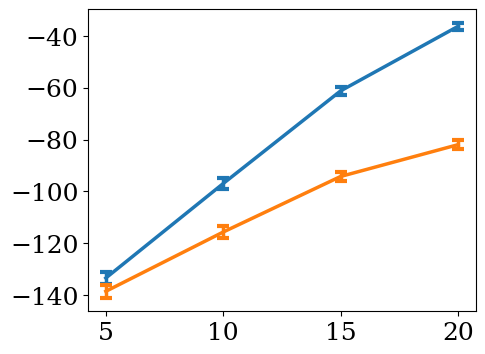

In [41]:
fig = plt.figure(figsize=figsiz_)
x= ncontext_list

#convcnp
y1,y11 = result_dict['base']['m'],result_dict['base']['s']
plt.errorbar(x, y1, yerr = y11 , label='base', linewidth=linewidth_, capsize=capsize_, capthick=capthick_)

# #gpind
# y1,y11 = result_dict['gpind']['m'],result_dict['gpind']['s']
# plt.errorbar(x, y1, yerr = y11  , label='gpind', linewidth=linewidth_, capsize=capsize_, capthick=capthick_)

#gpdep
y1,y11 = result_dict['gpdep']['m'],result_dict['gpdep']['s']
plt.errorbar(x, y1, yerr = y11  , label='gpdep', linewidth=linewidth_, capsize=capsize_, capthick=capthick_)

#gpdep2
y1,y11 = result_dict['gpdep2']['m'],result_dict['gpdep2']['s']
plt.errorbar(x, y1, yerr = y11  , label='gpdep2', linewidth=linewidth_, capsize=capsize_, capthick=capthick_)




plt.xlabel('#context set',fontsize=fontsiz-2)
plt.ylabel('test log likelihood',fontsize=fontsiz-2)

plt.xticks(xticks_,fontsize=fontsiz-2)
#plt.yticks(yticks_,fontsize=fontsiz-4)
plt.yticks(fontsize=fontsiz-4)

plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.gca().yaxis.get_offset_text().set_size(fontsiz_-6)


leg = plt.legend(fontsize=fontsiz_-3,handlelength= 1.2, columnspacing =1.0)
#leg = plt.legend(loc = 'lower left',fontsize=fontsiz_-4,ncol=5,handlelength= 1.2, columnspacing =1.0)
for ii in leg.legendHandles:
    ii.set_linewidth(3)     

  

fig.tight_layout()    
savefigname = './' + datatype + '_comparison_ntarget{}'.format(ntarget) 
#plt.savefig(savefigname  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
plt.show()
    
savefigname 

In [54]:
#context_x

## analysis on functional features

In [75]:
saved_modelparam_path = saved_modelparam_path1


modelspec =  saved_modelparam_path.split('/')[-1][:-4]
modelname = saved_modelparam_path.split('/')[-1].split('_')[0]
cnntype = saved_modelparam_path.split('/')[-1].split('_')[1]

#model,_ = build_model(model_type=model_type)
model,_,lossfun = get_model(modelname=modelname,cnntype=cnntype)

load_dict = torch.load(saved_modelparam_path)
model.load_state_dict(load_dict['state_dict'])   
print(model)
print('\n\n')
#print(model.gpsampler.kernel.prepare_cross_params())


Convcnp(
  (activation): Sigmoid()
  (sigma_fn): Softplus(beta=1, threshold=20)
  (encoder): ConvDeepSet(
    (g): Sequential(
      (0): Linear(in_features=8, out_features=8, bias=True)
    )
  )
  (cnn): cnn_shallow(
    (cnn): Sequential(
      (0): Conv1d(8, 16, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): ReLU()
      (2): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
      (3): ReLU()
      (4): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
      (5): ReLU()
      (6): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
      (7): ReLU()
      (8): Conv1d(16, 8, kernel_size=(5,), stride=(1,), padding=(2,))
    )
  )
  (cnn_linear): Sequential(
    (0): Linear(in_features=8, out_features=20, bias=True)
  )
  (mean_layer): FinalLayer(
    (g): Sequential(
      (0): Linear(in_features=5, out_features=1, bias=True)
    )
  )
  (logstd_layer): FinalLayer(
    (g): Sequential(
      (0): Linear(in_features=5, out_features=1, bias=True)
  

In [43]:
model.num_params

5648

In [79]:
#----------------------------------
# small datset
#----------------------------------
#ncontext,ntarget = 50,200
ncontext,ntarget = 10,30

#context_x,context_y,target_x,target_y = prepare_batch_new(dataset_dict , nbatch = 1,batch_npoints=(ncontext,ntarget), intrain = True)
context_x,context_y,target_x,target_y = prepare_batch_new(dataset_dict, nbatch = 1,batch_npoints=(ncontext,ntarget), intrain = False)
#context_x,context_y,target_x,target_y = prepare_batch_new(dataset_dict, nbatch = 1,batch_npoints=(ncontext,ntarget), intrain = False, forfig=True)


#min_x,max_x = 0.0,31.1
pred_xlb,pred_xub = torch.cat([context_x,target_x],dim=1).min().item()-0.1,torch.cat([context_x,target_x],dim=1).max().item()+0.1

#pred_xlb,pred_xub = dataset_dict['split_day'],max_x
#pred_xlb,pred_xub = min_x,dataset_dict['split_day']

full_x = torch.linspace(pred_xlb,pred_xub,3*ntarget)[None,:].repeat(num_channels,1).T
full_x = full_x[None,:,:]
full_x = full_x.unsqueeze(dim=-2)  

In [80]:
figsiz_ = (11,2.5*4)
#bidx=4
wspace_ = 0.5
hspace_ = 0.25
fontsiz_ = 18

ylim_ = [-2.5,2.5]
xlim_ = [pred_xlb,pred_xub]

#xlim_ = [0-0.01,max_x+0.01]
#pred_xlb,pred_xub = 14,16
#xlim_ = [min_x,max_x]
#xlim_ = [30,40]


yticks_ = [-1,0,1]
xticks_ = list(np.arange(int(xlim_[0]),int(xlim_[1]),dtype=np.int))[::5]

color_list = ['r','b','g','m']


In [81]:
#xc.size()

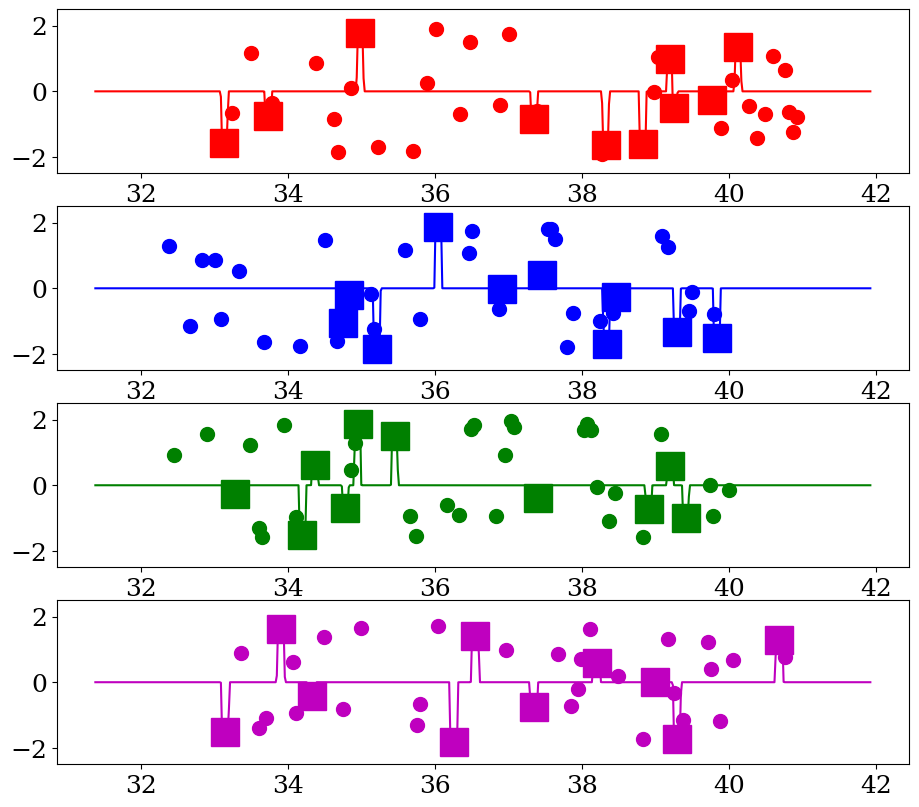

In [82]:
#context_x.shape,target_x.shape,full_x.shape


# xlim_=[3-delta,6+delta]
# ylim_=[-y_-delta,y_+delta]

num_channels=4
idx=0
#train_set = loaded['valid_set']
# xc = context_x[idx][...,None,:]
# yc = context_y[idx]
# xt = target_x[idx][idx][...,None,:]
# yt = target_y[idx]


xc = context_x[...,None,:]
yc = context_y
xt = target_x[...,None,:]
yt = target_y


tmp_numsamples=2
if model.modelname in proposed_model_list:    
    
    post_samples,xa = model.sample_functionalfeature(xc.cuda(),yc.cuda(),xt.cuda(),numsamples=tmp_numsamples)
    model.num_samples = tmp_numsamples 

else:    
    #xc = context_x
    #yc = context_y
    #xt = target_x
    #yt = target_y
    
    post_samples,xa = model.sample_functionalfeature(xc[:,:,0,:].cuda(),yc[0].cuda(),xt[:,:,0,:].cuda(),numsamples=1)
    post_samples = post_samples[:,None,:,:]



# #figsiz_=(15,3*nchannels)
# plt.figure(figsize=figsiz_)
# color_list = ['r','b','g','m']
# for i in range(num_channels):
#     plt.subplot(num_channels,1,i+1)
#     plt.plot(xc[0,:,0,i].cpu().data.numpy(),yc[0,:,i].cpu().data.numpy(),color_list[i]+'s',markersize=20)     
#     plt.plot(xt[0,:,0,i].cpu().data.numpy(),yt[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=10)     
    
#     #plt.plot(xa[0,:,0].cpu().data.numpy(),prior_samples[0,:,i].cpu().data.numpy(),color_list[i]+'-s',markersize=3)            
    
#     #plt.plot(xt[0,:,0,i].cpu().data.numpy(),pmu_xt[0,:,i].cpu().data.numpy(),color_list[i]+'s-')
#     plt.xlim(xlim_)
#     plt.ylim(ylim_)
# plt.show()



plt.figure(figsize=figsiz_)
#color_list = ['r','b','g']
for i in range(num_channels):
    plt.subplot(num_channels,1,i+1)
    #plt.plot(xt[0,:,0,i].cpu().data.numpy(),yt[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=10)     
    plt.plot(xc[0,:,0,i].cpu().data.numpy(),yc[0,:,i].cpu().data.numpy(),color_list[i]+'s',markersize=20)     
    plt.plot(xt[0,:,0,i].cpu().data.numpy(),yt[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=10)     
    
    for j in range(model.num_samples):
        #plt.plot(xa[0,:,0].cpu().data.numpy(),post_samples[0,j,:,i].cpu().data.numpy(),color_list[i]+'-s',markersize=2)        
        plt.plot(xa[0,:,0].cpu().data.numpy(),post_samples[0,j,:,i].cpu().data.numpy(),color_list[i])        

    #plt.xlim(xlim_)
    plt.ylim(ylim_)
plt.show()


In [83]:
#xc.shape

In [84]:
# post_samples,xa = model.sample_functionalfeature(xc[0].cuda(),yc[0].cuda(),xt[0].cuda(),numsamples=1)
# post_samples.shape

In [85]:
# xa,post_samples2,density,prior_yc = model.gpsampler.sample_posterior(xc.cuda(),yc.cuda(),xt.cuda(),numsamples=tmp_numsamples)



# #posterior_samples2.shape
# color_list = ['r','b','g','m']
# #post_samples2.shape

# figsiz2_ = [30,10.0]
# xlim_ = [0,5]
# plt.figure(figsize=figsiz2_)
# #color_list = ['r','b','g']
# for i in range(num_channels):
#     for j in range(num_channels):
#         plt.subplot(num_channels,num_channels,i*num_channels+j+1)
#         #plt.plot(xt[0,:,0,i].cpu().data.numpy(),yt[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=10)     
#         plt.plot(xc[0,:,0,i].cpu().data.numpy(),yc[0,:,i].cpu().data.numpy(),color_list[i]+'s',markersize=20)     
#         plt.plot(xt[0,:,0,i].cpu().data.numpy(),yt[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=10)     

#         for k in range(model.num_samples):
#             #plt.plot(xa[0,:,0].cpu().data.numpy(),post_samples[0,j,:,i].cpu().data.numpy(),color_list[i]+'-s',markersize=2)        
#             plt.plot(xa[0,:,0].cpu().data.numpy(),post_samples2[0,k,:,i*num_channels+j].cpu().data.numpy(),color_list[i])        

#         plt.xlim(xlim_)
#         plt.ylim(ylim_)
# plt.show()


In [86]:
#post_samples2.shape
#yc.shape
#post_samples2.shape

In [87]:
#Model averages a log likelihood of -47.28 on unseen tasks.
saved_model_path = './fig/exp2_waterdepth/'
datatype = 'waterdepth'

## prediction

In [99]:
saved_modelparam_path = saved_modelparam_path1



modelspec =  saved_modelparam_path.split('/')[-1][:-4]
modelname = saved_modelparam_path.split('/')[-1].split('_')[0]
cnntype = saved_modelparam_path.split('/')[-1].split('_')[1]

#model,_ = build_model(model_type=model_type)
model,_,lossfun = get_model(modelname=modelname,cnntype=cnntype)

load_dict = torch.load(saved_modelparam_path)
model.load_state_dict(load_dict['state_dict'])   
print(model)
# print('\n\n')
# print(model.gpsampler.kernel.prepare_cross_params())



Convcnp(
  (activation): Sigmoid()
  (sigma_fn): Softplus(beta=1, threshold=20)
  (encoder): ConvDeepSet(
    (g): Sequential(
      (0): Linear(in_features=8, out_features=8, bias=True)
    )
  )
  (cnn): cnn_shallow(
    (cnn): Sequential(
      (0): Conv1d(8, 16, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): ReLU()
      (2): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
      (3): ReLU()
      (4): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
      (5): ReLU()
      (6): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
      (7): ReLU()
      (8): Conv1d(16, 8, kernel_size=(5,), stride=(1,), padding=(2,))
    )
  )
  (cnn_linear): Sequential(
    (0): Linear(in_features=8, out_features=20, bias=True)
  )
  (mean_layer): FinalLayer(
    (g): Sequential(
      (0): Linear(in_features=5, out_features=1, bias=True)
    )
  )
  (logstd_layer): FinalLayer(
    (g): Sequential(
      (0): Linear(in_features=5, out_features=1, bias=True)
  

In [100]:
#model.gpsampler.kernel.loglik.exp()

In [101]:

#----------------------------------
# small datset
#----------------------------------
#ncontext,ntarget = 50,200
ncontext,ntarget = 15,30

#context_x,context_y,target_x,target_y = prepare_batch_new(dataset_dict, nbatch = 1,batch_npoints=(ncontext,ntarget), intrain = True)
context_x,context_y,target_x,target_y = prepare_batch_new(dataset_dict, nbatch = 1,batch_npoints=(ncontext,ntarget), intrain = False)
#context_x,context_y,target_x,target_y = prepare_batch_new(dataset_dict, nbatch = 1,batch_npoints=(ncontext,ntarget), intrain = False, forfig=True)

#context_x,context_y,target_x,target_y = prepare_batch_new(dataset_dict, time_dict_index , nbatch = 1,batch_npoints=(ncontext,ntarget), intrain = False)

#min_x,max_x = 0.0,61.1
#pred_xlb,pred_xub = dataset_dict['split_day'],max_x
pred_xlb,pred_xub = torch.cat([context_x,target_x],dim=1).min().item()-0.1,torch.cat([context_x,target_x],dim=1).max().item()+0.1
#pred_xlb,pred_xub = min_x,dataset_dict['split_day']
full_x = torch.linspace(pred_xlb,pred_xub,2*(ncontext+ntarget))[None,:].repeat(num_channels,1).T
full_x = full_x[None,:,:]







if model.modelname in proposed_model_list and len(context_x.size()) == 3:        
    context_x,target_x=context_x.unsqueeze(dim=-2),target_x.unsqueeze(dim=-2)        
    full_x = full_x.unsqueeze(dim=-2)        
else:
    context_x,target_x=context_x.squeeze(),target_x.squeeze()        
    full_x = full_x.squeeze()        

    if len(context_x.shape)==2:
        context_x = context_x[None,:,:] 
        target_x = target_x[None,:,:] 
        full_x = full_x[None,:,:] 


#full_x = target_x        
        
model.eval()
y_mean, y_std = model(context_x.cuda(),context_y.cuda(),full_x.cuda())





#y_mean, y_std = predict_cross(context_x,context_y,target_x,target_y)
y_mean = y_mean.squeeze().cpu().data.numpy()
y_std = y_std.squeeze().cpu().data.numpy()



context_x_ = context_x.squeeze().cpu().data.numpy()
context_y_ = context_y.squeeze().cpu().data.numpy()
target_x_ = target_x.squeeze().cpu().data.numpy()
target_y_ = target_y.squeeze().cpu().data.numpy()
full_x_ = full_x.squeeze().cpu().data.numpy()



## figures

In [102]:
figsiz_ = (11,2.5*4)
#bidx=4
wspace_ = 0.5
hspace_ = 0.25
fontsiz_ = 18

ylim_ = [-2.5,2.5]
#xlim_ = [0-0.01,max_x+0.01]

#pred_xlb,pred_xub=0,60
pred_xlb,pred_xub = torch.cat([context_x,target_x],dim=1).min().item()-0.1,torch.cat([context_x,target_x],dim=1).max().item()+0.1

xlim_ = [pred_xlb,pred_xub]

#xlim_ = [10,29.1]

yticks_ = [-1,0,1]
xticks_ = list(np.arange(int(xlim_[0]),int(xlim_[1]),dtype=np.int))[::5]

In [103]:
pred_xlb,pred_xub

(40.95902862548828, 51.01666793823242)

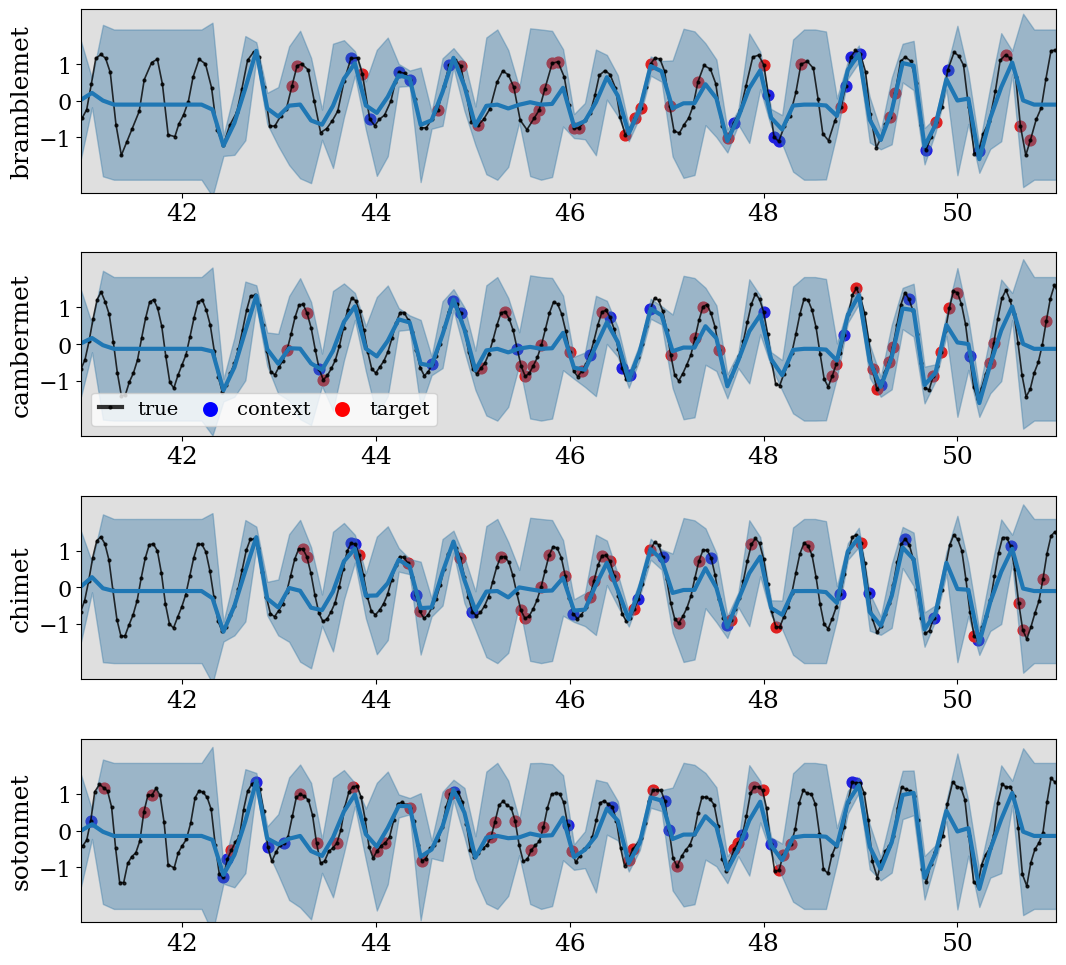

In [104]:
#cols[1] = 'Temperature'


#xlim_ = [0,220]

fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace= wspace_, hspace= hspace_)

for j in range(num_channels):
    #plt.subplot(nchannels//2,2,j+1)
    plt.subplot(num_channels,1,j+1)
    
    #imputation region
    #xb = target_x[:,j].min()+0.1,target_x[:,j].max()+0.1
    #s_idx,e_idx = time_dict_index[j]['target_idx'][0],time_dict_index[j]['target_idx'][-1]
    #xb = dataset_dict[j]['x'][s_idx], dataset_dict[j]['x'][e_idx]
    #plt.axvspan(xmin = n_time_split ,xmax = xlim_[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label='beyond training')
    plt.axvspan(xmin = dataset_dict['split_day'] ,xmax = xlim_[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)

    #dataset
    plt.scatter(context_x_[:,j],context_y_[:,j],color = 'b',label = 'context',s=60)
    plt.scatter(target_x_[:,j],target_y_[:,j],color = 'r',label = 'target',s=60)
    #plt.plot(dataset_dict[j]['x'],dataset_dict[j]['y'],'k',label='true',linewidth=1.5)
    plt.plot(dataset_dict[j]['x'],dataset_dict[j]['y'],'k-o',label='true',markersize=2,linewidth=1.2,alpha=0.8)
    

#     plt.plot(target_x[:,j],y_mean[:,j],color='tab:blue',linewidth=3.0,label='model')
#     plt.fill_between(target_x[:,j],
#                      y_mean[:,j] + 2 * y_std[:,j],
#                      y_mean[:,j] - 2 * y_std[:,j],
#                      color='tab:blue', alpha=0.4)

    if len(y_mean.shape)==2:
        plt.plot(full_x_[:,j],y_mean[:,j],color='tab:blue',linewidth=3.0)
        plt.fill_between(full_x_[:,j],
                         y_mean[:,j] + 2 * y_std[:,j],
                         y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=0.4)

        
    if len(y_mean.shape)==3:
        for kk in range(1):
            plt.plot(full_x_[:,j],y_mean[kk,:,j],color='tab:blue',linewidth=3.0)
            plt.fill_between(full_x_[:,j],
                             y_mean[kk,:,j] + 2 * y_std[kk,:,j],
                             y_mean[kk,:,j] - 2 * y_std[kk,:,j],
                             color='tab:blue', alpha=0.4)
        

#     if j == num_channels:
#         plt.xticks(np.linspace(0,3.,6),np.linspace(0,3.,6))
#     else:
#         plt.xticks([])
    plt.xlim(xlim_)
    plt.ylim(ylim_)     
    #python3 test_realdataset_metatask.py  --modelname gpdep    --datav $datav --dataname $dataname   --initl $l_scale --nepochs $nepochs ;    

    #plt.ylabel('{} ch'.format(j+1),fontsize=fontsiz_)
    plt.ylabel('{}'.format(cols[j]),fontsize=fontsiz_)
    #plt.xlim(xlim_)
    plt.yticks(yticks_,fontsize=fontsiz_-2)
    #plt.xticks(xticks_,fontsize=fontsiz_-2)

    #if j == 0:
    #    leg = plt.legend(loc = 'upper left',bbox_to_anchor=(.05,1.50),fontsize=fontsiz_,ncol=5,handlelength= 1.5, columnspacing =1.5)
    #    for ii in leg.legendHandles:
    #        ii.set_linewidth(2)      

    
    if j == 1:
        leg = plt.legend(loc = 'lower left',fontsize=fontsiz_-4,ncol=5,handlelength= 1.2, columnspacing =1.0)
        for ii in leg.legendHandles:
            ii.set_linewidth(3)      

    

fig.tight_layout()    
#plt.savefig(saved_model_path + datatype + '_imputation'+'_convcnp'  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
plt.show()
#'./'+datatype + '_imputation'+'convcnp'  + '.pdf'


In [105]:
wspace_ = 0.5
hspace_ = 0.25
fontsiz_ = 18

#ylim_ = [-4,4.5]
#figsiz_ = (12,3.5)
#xlim_ = [10,29.1]

figsiz_ = (11,num_channels*2.5)
#xlim_ = [0-0.1,29+0.1]



deltay=0.99
ylim_ = [1 - deltay,5 + deltay]
yticks_ = [1,3,5]
fontsiz_ = 18

ybound = [-10,10]

In [106]:
#context_x_

In [107]:
#xlim_=[dataset_dict['split_day'],30]
#xticks_ = list(np.arange(int(xlim_[0]),int(xlim_[1]+1),dtype=np.int))[::2]

/home/becre1776/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


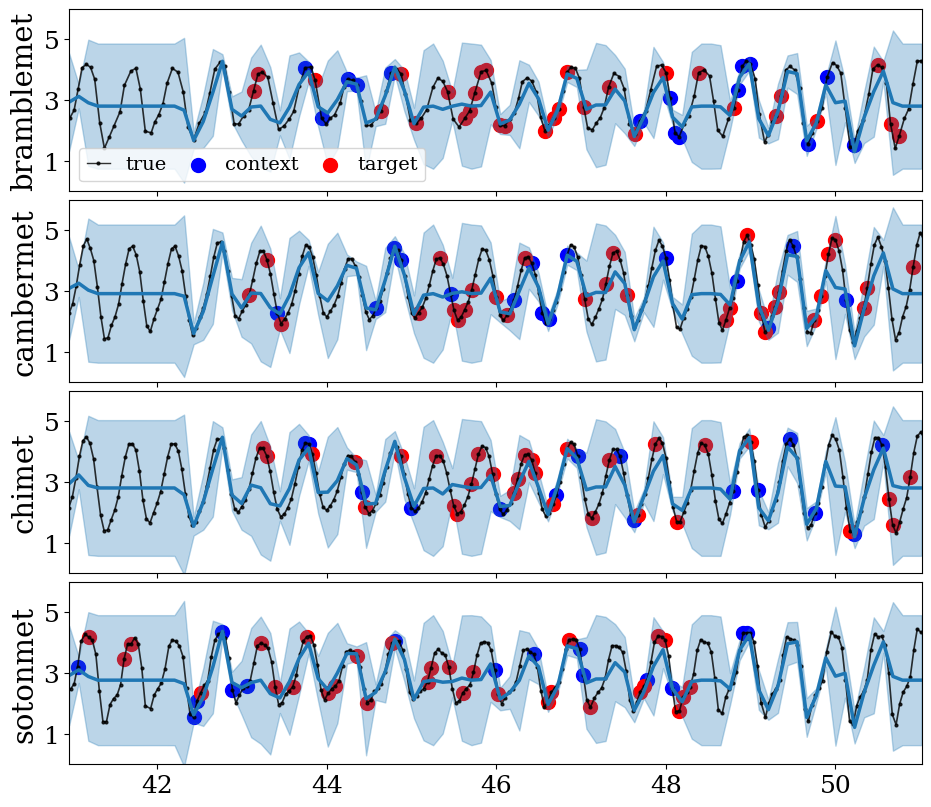

base_shallow_nepochs3000_initl0.01_waterdepth_full


In [108]:
#xlim_ = [0,220]

#fig = plt.figure(figsize=figsiz_)
fig, axs = plt.subplots(num_channels, figsize=figsiz_, ncols=1, sharex=True , gridspec_kw={'hspace': 0.05})
#fig.subplots_adjust(top=0.95, bottom=0.05, left=0.17, right=0.845, wspace=0,hspace=0)
#fig.subplots_adjust( wspace=0,hspace=0)

for j in range(num_channels):
    #outrain regeion    
    #axs[j].axvspan(xmin = dataset_dict['split_day'] ,xmax = xlim_[1], ymin = ybound[0], ymax = ybound[1],color='gray', alpha=0.4,label='beyond training range')

    #dataset
    transformed_context_y = dataset_dict[j]['ymean'] + dataset_dict[j]['ystd']*context_y_[:,j]
    transformed_target_y = dataset_dict[j]['ymean'] + dataset_dict[j]['ystd']*target_y_[:,j]    
    transformed_y = dataset_dict[j]['ymean'] + dataset_dict[j]['ystd']*dataset_dict[j]['y']
        
    axs[j].scatter(context_x_[:,j],transformed_context_y,color = 'b',label = 'context',s=100)
    axs[j].scatter(target_x_[:,j],transformed_target_y,color = 'r',label = 'target',s=100)    
    #axs[j].plot(dataset_dict[j]['x'],transformed_y,'k',label='true',linewidth=2.)
    axs[j].plot(dataset_dict[j]['x'],transformed_y,'k-o',label='true',markersize=2,linewidth=1.2,alpha=0.8)
    

    
    if len(y_mean.shape)==2:
        transformed_ymean = dataset_dict[j]['ymean'] + dataset_dict[j]['ystd']*y_mean[:,j]
        transformed_ystd = dataset_dict[j]['ystd']*y_std[:,j]
        
        
        axs[j].plot(full_x_[:,j], transformed_ymean,color='tab:blue',linewidth=2.5)
        axs[j].fill_between(full_x_[:,j],
                            transformed_ymean + 2 *  transformed_ystd,
                            transformed_ymean - 2 *  transformed_ystd,
                            color='tab:blue', alpha=0.3)

        
    if len(y_mean.shape)==3:
        transformed_ymean = dataset_dict[j]['ymean'] + dataset_dict[j]['ystd']*y_mean[:,:,j]
        transformed_ystd = dataset_dict[j]['ystd']*y_std[:,:,j]
        
        
        for kk in range(3):
            axs[j].plot(full_x_[:,j],transformed_ymean[kk,:],color='tab:blue',linewidth=2.5)
            axs[j].fill_between(full_x_[:,j],
                                transformed_ymean[kk,:] + 2 * transformed_ystd[kk,:],
                                transformed_ymean[kk,:] - 2 * transformed_ystd[kk,:],
                                color='tab:blue', alpha=0.3)
        
#        #average figures
#         axs[j].plot(full_x_[:,j],transformed_ymean.mean(axis=0),color='tab:blue',linewidth=2.5)
#         axs[j].fill_between(full_x_[:,j],
#                             transformed_ymean.mean(axis=0) + 2 * transformed_ystd.mean(axis=0),
#                             transformed_ymean.mean(axis=0) - 2 * transformed_ystd.mean(axis=0),
#                             color='tab:blue', alpha=0.3)


    
    axs[j].set(xlim=xlim_,ylim=ylim_)
    #plt.ylabel('{} ch'.format(j+1),fontsize=fontsiz_)
    axs[j].set_ylabel('{}'.format(cols[j]),fontsize=fontsiz_+3)
    #plt.xlim(xlim_)
    axs[j].set_yticks(yticks_)

    #plt.xlim(xlim_)
    #plt.ylim(ylim_)

    
    if j == 0:
        leg = axs[j].legend(loc = 'lower left',fontsize=fontsiz_-4.,ncol=5,handlelength= 1.2, columnspacing =1.0)
        for ii in leg.legendHandles:
            ii.set_linewidth(1)      
        
    #plt.xticks(xticks_,fontsize=fontsiz_-2)
    #plt.xticks([],fontsize=fontsiz_-2)        
    if j==3:
        #axs[j].set_xticks(xticks_)
        pass
    else:
        #axs[j].set_xticks()
        pass


    

fig.tight_layout()    
#plt.savefig(saved_model_path + datatype + '_imputation'+'_convcnp'  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
#plt.savefig(saved_model_path + modelspec + '_' + datatype + '_ch{}'.format(j)  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
#savefigname =  modelspec + '_' + datatype + '_ch{}'.format(j)
savefigname =  modelspec + '_' + datatype + '_full'
#plt.savefig('./'  + savefigname   + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()
    
    #plt.show()
#'./'+datatype + '_imputation'+'convcnp'  + '.pdf'
print(savefigname )

In [131]:
#

In [ ]:














# def nparray2tensor(context_x,context_y,target_x,target_y):
#     return torch.tensor(context_x).float(),\
#            torch.tensor(context_y).float(),\
#            torch.tensor(target_x).float(),\
#            torch.tensor(target_y).float()


# #ma
# def prepare_batch_new(dataset_dict , nbatch = 32,batch_npoints=(64,64), intrain = True, forfig = False,num_channels=4):
#     context_x,context_y = [],[]
#     target_x,target_y = [],[]
#     full_x,full_y = [],[]
    
#     #n_points = len(x)
#     #time_dict_index = get_index(dataset_dict,test_option = test_option,test_len=test_len)
#     split_day = dataset_dict['split_day']
#     for _ in range(nbatch):

#         i_context_x,i_context_y = [],[]
#         i_target_x,i_target_y = [],[]
#         i_full_x,i_full_y = [],[]
#         #for ith_channel in timedict_index:
        
#         if intrain and not forfig:
#             chosenday = np.random.randint(5,split_day - 4)
#         if not intrain and not forfig:                
#             chosenday = np.random.randint(split_day+4,dataset_dict['total_day'] - 4)
#         if not intrain and  forfig:                
#             chosenday = np.random.randint(split_day+4,dataset_dict['total_day'] - 4)
                        
#         #print(dayindex)
                
#         #for ith_channel in dataset_dict.keys():    
#         for ith_channel in range(num_channels):    
            
#             if not forfig:                
#                 #v1
#                 #index_candidate = np.where(   (chosenday-1<dataset_dict[ith_channel]['x'])  & (dataset_dict[ith_channel]['x']<(chosenday+1)  ))[0]
#                 #v2
#                 #index_candidate = np.where(   (chosenday-3.5<dataset_dict[ith_channel]['x'])  & 
#                 #                              (dataset_dict[ith_channel]['x']<(chosenday + 3.5)  ))[0]
                
#                 index_candidate = np.where(   (chosenday-1.5<dataset_dict[ith_channel]['x'])  &  
#                                               (dataset_dict[ith_channel]['x']<(chosenday+1.5)  ))[0] 


# #                 index_candidate = np.where(   (chosenday-3.5<dataset_dict[ith_channel]['x'])  &  
# #                                               (dataset_dict[ith_channel]['x']<(chosenday+3.5)  ))[0] 

#                 #print(index_candidate)
#                 assert len(index_candidate) >= batch_npoints[0]+batch_npoints[1]
                
#             else:
#                 #index_candidate = np.arange(len(dataset_dict[ith_channel]['x']))

#                 #v1: full region                
#                 #index_candidate = np.where(   dataset_dict[ith_channel]['x'] >= split_day  )[0]

#                 #v2: test region                
#                 index_candidate = np.where(   (dataset_dict[ith_channel]['x'] >= split_day + 4*1))[0]

# #                 #v3: test region                                
# #                 index_candidate = np.where(   (chosenday-3.5<dataset_dict[ith_channel]['x'])  &
# #                                                (dataset_dict[ith_channel]['x']<(chosenday + 3.5)  ))[0]
                
#             #print(index_candidate)

                
#             #set index    
#             sampled_c_idx = np.sort(np.random.choice(index_candidate,batch_npoints[0],replace=False))
#             left_c_idx = np.setdiff1d(index_candidate,sampled_c_idx)
#             sampled_t_idx = np.sort(np.random.choice(left_c_idx,  min(batch_npoints[1],len(left_c_idx)),replace=False ))
                
#             #get context and target set     
#             ith_context_x,ith_context_y = dataset_dict[ith_channel]['x'][sampled_c_idx],dataset_dict[ith_channel]['y'][sampled_c_idx]
#             ith_target_x,ith_target_y = dataset_dict[ith_channel]['x'][sampled_t_idx],dataset_dict[ith_channel]['y'][sampled_t_idx]        


#             i_context_x.append(ith_context_x)
#             i_context_y.append(ith_context_y) 
#             i_target_x.append(ith_target_x)
#             i_target_y.append(ith_target_y) 



#         i_context_x,i_context_y = np.asarray(i_context_x).T,np.asarray(i_context_y).T
#         i_target_x,i_target_y = np.asarray(i_target_x).T,np.asarray(i_target_y).T   
#         i_full_x,i_full_y = np.asarray(i_full_x).T,np.asarray(i_full_y).T   

        
#         context_x.append( i_context_x )
#         context_y.append( i_context_y )
#         target_x.append( i_target_x  )
#         target_y.append( i_target_y )
#         #full_x.append(i_full_x)
#         #full_y.append(i_full_y)
    
#     #print(type(context_x))        

#     context_x = np.asarray(context_x,dtype=np.float32)
#     context_y = np.asarray(context_y,dtype=np.float32)
#     target_x = np.asarray(target_x,dtype=np.float32)
#     target_y = np.asarray(target_y,dtype=np.float32)
#     full_x = np.asarray(full_x,dtype=np.float32)
#     full_y = np.asarray(full_y,dtype=np.float32)
        
#     context_x,context_y,target_x,target_y = nparray2tensor(context_x,context_y,target_x,target_y)
#     return context_x,context_y,target_x,target_y
